# General 

Notebook used for data exploration and model training and testing

In [99]:
import pandas as pd
import numpy as np
import cv2    
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [101]:
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

In [102]:
DIR = 'img/'
df = pd.read_csv('labels.csv', sep = '\s+')
df.set_index('file_name',inplace=True)
df.head()

,eye_color,face_shape
file_name,,
0.png,1,4
1.png,2,4
2.png,2,3
3.png,2,0
4.png,0,2


# NEED TO REMOVE PICS WITH SUN GLASSES AND BEARD

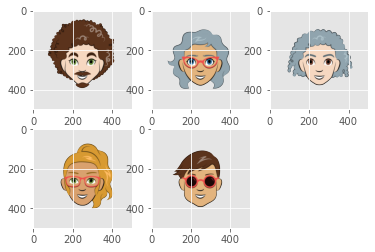

In [103]:
plt.subplot(231)
plt.imshow(plt.imread(DIR+'3.png'))
plt.subplot(232)
plt.imshow(plt.imread(DIR+'8.png'))
plt.subplot(233)
plt.imshow(plt.imread(DIR+'4.png'))
plt.subplot(234)
plt.imshow(plt.imread(DIR+'2.png'))
plt.subplot(235)
plt.imshow(plt.imread(DIR+'18.png'))

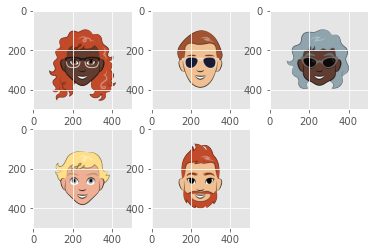

In [104]:
plt.subplot(231)
plt.imshow(plt.imread(DIR+'12.png'))
plt.subplot(232)
plt.imshow(plt.imread(DIR+'27.png'))
plt.subplot(233)
plt.imshow(plt.imread(DIR+'1.png'))
plt.subplot(234)
plt.imshow(plt.imread(DIR+'6.png'))
plt.subplot(235)
plt.imshow(plt.imread(DIR+'5.png'))

# Cropping faces

In [106]:
def crop(img_path):
    img = cv2.imread(img_path)
    face = img[280:400,150:350] #(120 200)
    face = cv2.resize(face,(50,32))
    eye = cv2.resize(img[250:280,190:220]) #(30,30)
    eye = cv2.resize(eye,(10,10))
    return face, eye

# crop and save everything

In [80]:
x_faces = []
x_eyes = []

y_face = []
y_eye = []

DIR_face = './faces_no_glasses/'
DIR_eye = './eyes_no_glasses/'
#x[0][0] = eye_color
#    [1] = face_shape
start = time.time()
for x in df_gl.iterrows():
    face, eye = crop(DIR+x[0])
    
    x_faces.append(face)
    x_eyes.append(eye)
    
    y_eye.append(x[1][0])
    y_face.append(x[1][1])
    
    result=cv2.imwrite(DIR_face+x[0],face)
    result=cv2.imwrite(DIR_eye+x[0],eye)
    
end = time.time()
print('elapsed time: ' +str(end-start))

elapsed time: 41.75768828392029


# Remove glasses

In [107]:
DIR_eye = './eyes/'
DIR = './img/'
DIR_n = './no_glasses/'
df_gl = df.copy()
#load each img in the dir
comp = [[255,255,255]] #white row
for x in df.index:
    ori = cv2.imread(DIR_eye+x)
    ori = np.array(ori).reshape(100,3)
    for j in range(len(ori)-1): #compare rows
        if (ori[j] == comp[0]).all(): #if the row is completelly white
            img = cv2.imread(DIR+x)
            #result=cv2.imwrite(DIR_n+x,img)
            break
        if j == len(ori)-2:
            df_gl.drop(index=x,inplace=True)

In [110]:
df_gl.to_csv('df_no_glasses.csv')

Load new dataset

In [112]:
DIR_eye = './eyes/'
DIR_face = './faces/'

x_faces = []
x_eyes = []

y_face = []
y_eye = []

for x in df_gl.iterrows():
    eye = cv2.imread(DIR_eye+x[0])
    face = cv2.imread(DIR_face+x[0])
    
    x_faces.append(face)
    x_eyes.append(eye)
    
    y_eye.append(x[1][0])
    y_face.append(x[1][1])

In [115]:
len(x_faces)

7736

In [239]:
x_faces[1].shape

(4800,)

In [238]:
x_faces = np.array(x_faces).reshape(len(x_faces),4800 )
x_eyes = np.array(x_eyes).reshape(len(x_eyes),300)

ValueError: cannot reshape array of size 37132800 into shape (7736,)

In [117]:
print(np.unique(y_eye,return_counts=True)) #balance classes
print(np.unique(y_face,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int64), array([1569, 1559, 1517, 1540, 1551], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([1537, 1556, 1548, 1531, 1564], dtype=int64))


# How to crop faces
1. Train haar cascades to do it automatically for face an eyes
2. Manually cut them

1. need to remove people with sunglasses from eye colo detection set
2. reomve people with beards from face shape detector

# Fit cropped images to xgb / lda / svm / knn

In [118]:
#Train for eyes
X = x_faces
y = y_face

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y_face)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [119]:
print(len(X_train),len(X_val),len(X_test))

4950 1238 1548


In [212]:
X_train[1].shape

(300,)

In [144]:
#XGB
start = time.time()
model = xgb.XGBClassifier(n_estimators=10, learning_rate=100)
print(model)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

XGBClassifier(learning_rate=100, n_estimators=10)
1.0
elapsed time: 0.6881353855133057


In [160]:
x_faces[1].shape

(4800,)

In [92]:
#SVM
start = time.time()
model = SVC()
print(model)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.9941860465116279
elapsed time: 71.22483968734741


In [93]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier()
print(model)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8843669250645995
elapsed time: 66.85257339477539


In [96]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start = time.time()
model = LinearDiscriminantAnalysis()
print(model)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

LinearDiscriminantAnalysis()
0.9812661498708011
elapsed time: 45.2672917842865


In [123]:
#Train for eyes
X = x_eyes
y = y_eye

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y_face)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [124]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start = time.time()
model = LinearDiscriminantAnalysis()
print(model)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

LinearDiscriminantAnalysis()
1.0
elapsed time: 0.24987339973449707


In [161]:
>>> from sklearn.model_selection import cross_val_score
>>> clf = LinearDiscriminantAnalysis()
>>> scores = cross_val_score(clf, x_faces, y_face, cv=5)
>>> scores

array([0.98514212, 0.98771816, 0.98771816, 0.98836458, 0.98771816])

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

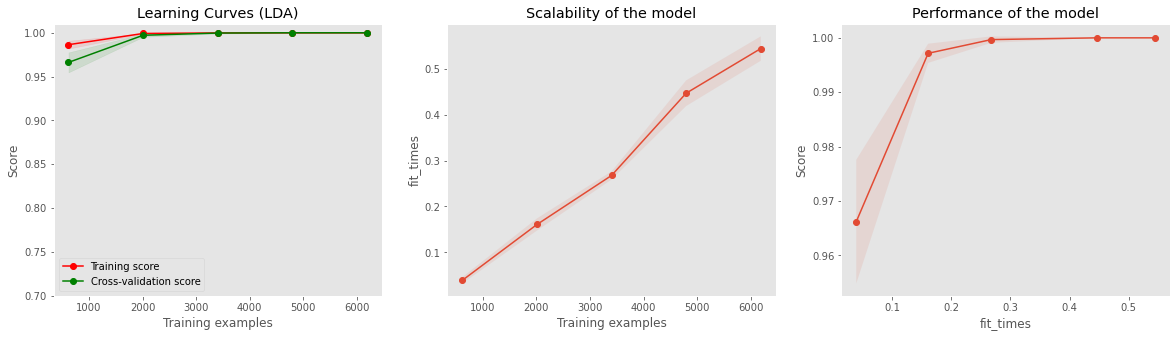

In [155]:
title = "Learning Curves (LDA)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

#estimator = LinearDiscriminantAnalysis()
estimator = SVC()
plot_learning_curve(estimator, title, x_eyes, y_eye, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [166]:
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

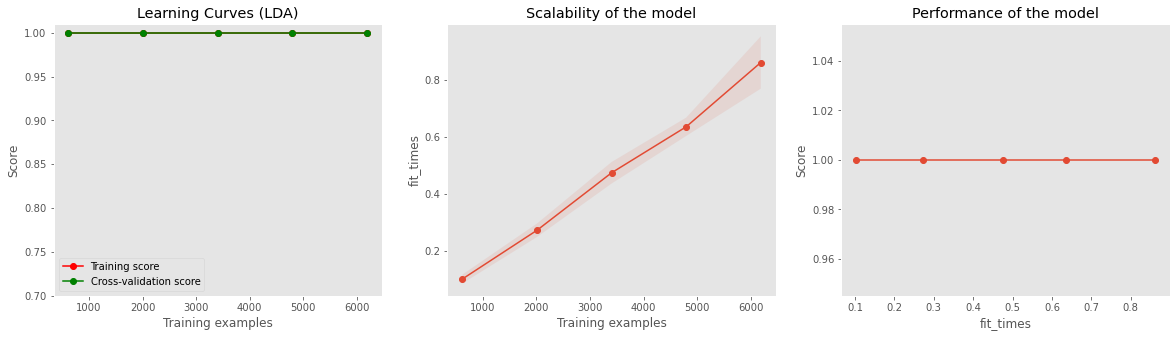

In [168]:
title = "Learning Curves (LDA)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LinearDiscriminantAnalysis()
#estimator = SVC()
plot_learning_curve(estimator, title, x_eyes, y_eye, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [169]:
DIR = './cartoon_set_test/test_img/'
df = pd.read_csv('./cartoon_set_test/test_labels.csv', sep = '\s+')
df.set_index('file_name',inplace=True)
df.head()

,eye_color,face_shape
file_name,,
0.png,2,1
1.png,1,4
2.png,0,2
3.png,0,2
4.png,3,3


In [186]:
x_faces_test = []
x_eyes_test = []

y_face_test = []
y_eye_test = []

#DIR_face = './faces_no_glasses/'
#DIR_eye = './eyes_no_glasses/'
#x[0][0] = eye_color
#    [1] = face_shape
start = time.time()
for x in df.iterrows():

    face, eye = crop(DIR+x[0])
    
    x_faces_test.append(face)
    x_eyes_test.append(eye)
    
    y_eye_test.append(x[1][0])
    y_face_test.append(x[1][1])
    
    #result=cv2.imwrite(DIR_face+x[0],face)
    #result=cv2.imwrite(DIR_eye+x[0],eye)
    
end = time.time()
print('elapsed time: ' +str(end-start))

elapsed time: 21.703964710235596


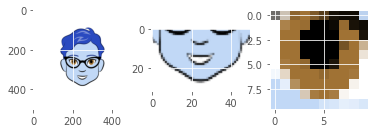

In [235]:
plt.subplot(131)
plt.imshow(cv2.imread(DIR+'1.png'))
plt.subplot(132)
plt.imshow(x_faces_test[1])
plt.subplot(133)
plt.imshow(x_eyes_test[1])

In [185]:
def crop(img_path):
    img = cv2.imread(img_path)
    face = img[280:400,150:350] #(120 200)
    face = cv2.resize(face,(50,32))
    eye = cv2.resize(img[250:280,190:220],(30,30))
    eye = cv2.resize(eye,(10,10))
    return face, eye

In [ ]:
dft_gl = df.copy()
#load each img in the dir
comp = [[255,255,255]] #white row
for x in df.index:
    ori = cv2.imread(DIR_eye+x)
    ori = np.array(ori).reshape(100,3)
    for j in range(len(ori)-1): #compare rows
        if (ori[j] == comp[0]).all(): #if the row is completelly white
            img = cv2.imread(DIR+x)
            #result=cv2.imwrite(DIR_n+x,img)
            break
        if j == len(ori)-2:
            dft_gl.drop(index=x,inplace=True)

In [184]:
len(x_faces_test)

2500

In [219]:
dft_gl = df.copy()
x_e = []
x_f = []
for i in range(len(df)):
    ori = x_eyes_test[i]
    flat = np.array(ori).reshape(100,3)
    for j in range(len(flat)-1): #compare rows
        if (flat[j] == comp[0]).all(): #if the row is completelly white
            x_e.append(ori)
            x_f.append(x_faces_test[i])
            break
        if j == len(flat)-2:
            dft_gl.drop(index=df.index[i],inplace=True)

In [220]:
y_e_t = dft_gl.eye_color
y_f_t = dft_gl.face_shape

In [221]:
x_f = np.array(x_f).reshape(len(x_f),4800)
x_e = np.array(x_e).reshape(len(x_e),300)

In [226]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start = time.time()
model = LinearDiscriminantAnalysis()
print(model)
model.fit(x_eyes, y_eye)
print(model.score(x_e,y_e_t))
end = time.time()
print('elapsed time: ' +str(end-start))

LinearDiscriminantAnalysis()
1.0
elapsed time: 0.8604257106781006


In [223]:
print(model.score(x_f,y_f_t))

0.9901452282157677
